In [1]:
# Explore the behaviour of the system in the absence of any policy 
# Sobol analysis: To investigate which model inputs add variance to the model output (expected 
# annual damage and expected number of deaths) under no policy 

from __future__ import (unicode_literals, print_function, absolute_import,
                        division)
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, IntegerParameter,
                           Scenario)
import numpy as np
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from ema_workbench import Samplers
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.analysis import prim

In [2]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    dike_model, planning_steps = get_model_for_problem_formulation(2)

    # Build a user-defined scenario and policy:
    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
    reference_values.update({'discount rate {}'.format(n): 3.5 for n in planning_steps})
    scen1 = {}


    for key in dike_model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 0}
    zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    pol0 = {}

    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)

In [3]:
#dike_model.uncertainties
scen1

{'discount rate 0': 3.5,
 'discount rate 1': 3.5,
 'discount rate 2': 3.5,
 'A.0_ID flood wave shape': 4,
 'A.1_Bmax': 175,
 'A.1_pfail': 0.5,
 'A.1_Brate': 1.5,
 'A.2_Bmax': 175,
 'A.2_pfail': 0.5,
 'A.2_Brate': 1.5,
 'A.3_Bmax': 175,
 'A.3_pfail': 0.5,
 'A.3_Brate': 1.5,
 'A.4_Bmax': 175,
 'A.4_pfail': 0.5,
 'A.4_Brate': 1.5,
 'A.5_Bmax': 175,
 'A.5_pfail': 0.5,
 'A.5_Brate': 1.5}

In [4]:
problem = get_SALib_problem(dike_model.uncertainties)
problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [5]:
for unc in dike_model.uncertainties:
    print(repr(unc))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [6]:
# Perform Sobol analysis
n_scenarios= 10
policy = policy0

In [7]:
policy

Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0})

In [8]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policy, uncertainty_sampling=Samplers.SOBOL)
        
experiments, outcomes = results

problem = get_SALib_problem(dike_model.uncertainties)
y = outcomes 
    
sobol_indices1 = sobol.analyze(problem, outcomes['Expected Annual Damage'])

[MainProcess/INFO] pool started with 4 workers
/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 400 scenarios * 1 policies * 1 model(s) = 400 experiments
  0%|                                          | 1/400 [00:01<12:15,  1.84s/it]Traceback (most recent call last):
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py", line 246, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ema_workbench/em_framework/ema_multiprocessing.py", line 253, in ru

In [11]:
Si = sobol.analyze(problem, outcomes['Expected Annual Damage'],calc_second_order=True, print_to_console=True)

                                   ST       ST_conf
A.0_ID flood wave shape  6.530772e-04  9.981997e-04
A.1_Bmax                 3.406650e-02  7.788639e-02
A.1_Brate                1.106674e-09  2.959673e-09
A.1_pfail                5.240603e-01  1.042559e+00
A.2_Bmax                 7.365108e-07  1.255987e-06
A.2_Brate                6.215640e-08  1.360304e-07
A.2_pfail                2.564247e-02  4.434119e-02
A.3_Bmax                 6.593858e-03  2.281903e-02
A.3_Brate                1.381168e-06  4.779234e-06
A.3_pfail                3.380720e-01  4.850557e-01
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                4.978287e-03  8.865493e-03
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                5.978308e-03  1.205016e-02
discount rate 0          2.252711e-02  1.729465e-02
discount rate 1          3.446779e-02  5.023817e-02
discount rat

                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/Users/marcpeterstreng/opt/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


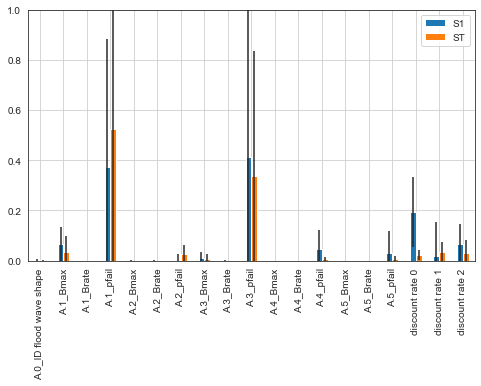

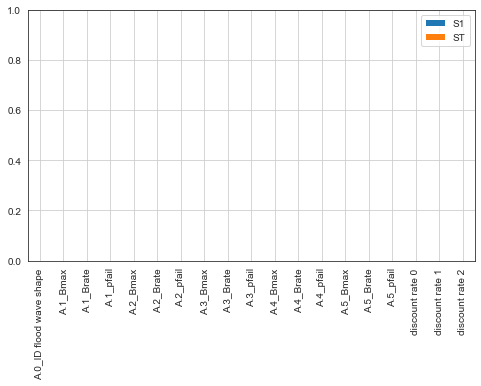

In [12]:
sobol_indices2 = sobol.analyze(problem, outcomes['Expected Number of Deaths'], print_to_console=True)

sobol_indices_list = [sobol_indices1, sobol_indices2]
    
for n in range(0,2):
    sobol_stats = {key:sobol_indices_list[n][key] for key in ['ST', 'ST_conf', 'S1','S1_conf']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
    sobol_stats.sort_values(by='ST', ascending=False)
        
    sns.set_style('white')
    fig, ax = plt.subplots(1)
        
    indices = sobol_stats[['S1','ST']]
    err = sobol_stats[['S1_conf','ST_conf']]
        
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.ylim([0,1])
    plt.grid()
        
plt.show()
    